In [ ]:
import time
!pip install -q pyomo
#Below snip of code install the GLPK solver into current python session
!apt-get install -y -qq glpk-utils
from pyomo.environ import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

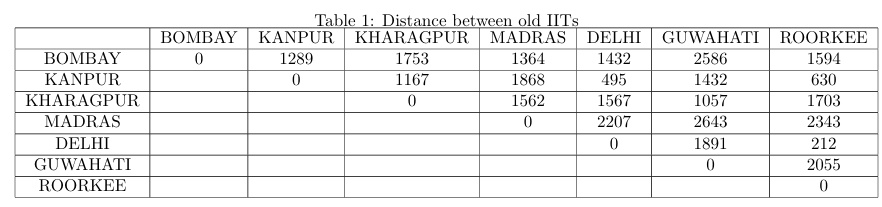

Let following be the indices for the cities to be used as vertices:

{Bombay: 0, Kanpur:1, Kharagpur:2, Madras:3, Delhi:4, Guwahati:5, Roorkee:6}


In [ ]:
distances = np.array([[0,1289,1753,1364,1432,2586,1594],
[0,0,1167,1868,495,1432,630],
[0,0,0,1562,1567,1057,1703],
[0,0,0,0,2207,2643,2343],
[0,0,0,0,0,1891,212],
[0,0,0,0,0,0,2055],
[0,0,0,0,0,0,0]])

In [ ]:
for i in range(distances.shape[0]):
  for j in range(distances.shape[1]):
    if i<j:
      distances[j,i] = distances[i,j]

In [ ]:
distances

array([[   0, 1289, 1753, 1364, 1432, 2586, 1594],
       [1289,    0, 1167, 1868,  495, 1432,  630],
       [1753, 1167,    0, 1562, 1567, 1057, 1703],
       [1364, 1868, 1562,    0, 2207, 2643, 2343],
       [1432,  495, 1567, 2207,    0, 1891,  212],
       [2586, 1432, 1057, 2643, 1891,    0, 2055],
       [1594,  630, 1703, 2343,  212, 2055,    0]])

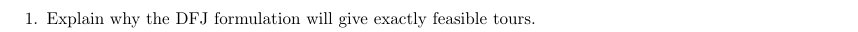

The DFJ (Dantzig, Fulkerson, Johnson) formulation is a mathematical model used to solve the Traveling Salesman Problem (TSP), which seeks to find the shortest possible tour that visits each city exactly once and returns to the starting city.

The DFJ formulation guarantees feasible tours because it enforces constraints that ensure each city is visited exactly once and that the tour forms a closed loop, returning to the starting city. Here's why it guarantees feasible tours:

We first observe the objective functions:

$
\text{Let } x_e \text{ be a binary decision variable representing whether edge } e \text{ is included in the tour.}
$$
x_e
\begin{cases}
     1 & \text{if edge } e \text{ is included in the tour} \\
     0 & \text{otherwise}
\end{cases}
$$
$

Then objective becomes to minimize the cost of selected edges, we get the objective as:

$$
\text{Minimize } \sum_{e \in E} c_e \cdot x_e
$$


**Visit Each City Exactly Once**: The DFJ formulation includes constraints that require every city to be visited exactly once. This is typically achieved through binary variables or indicator variables associated with each city, ensuring that only one incoming and one outgoing edge are selected for each city in the tour.

$$
\sum_{e \in \delta(i)} x_e = 2 \quad \forall i \in V
$$

This tells that each edge containing $i$, only two of them can be selected. One for incoming and one for outgoing.

**Form a Closed Loop**: To ensure that the tour forms a closed loop, the formulation includes constraints that prevent sub-tours. Sub-tours are sequences of cities that do not include all cities and thus violate the requirement of visiting each city in one tour. These constraints, often referred to as subtour elimination constraints, prevent the formation of sub-tours by specifying that the sum of variables associated with edges leaving any subset of cities must be less than the number of cities in that subset. This prevents the formation of disconnected tour segments.


$$
\sum_{e \in \delta(S)} x_e \geq 2 \quad \forall \phi ⊂ S ⊂ V
$$

Which tells us that each edge in the subset is incident to only one vertex which will help to prevent cycle in the subset.

By enforcing these constraints, the DFJ formulation ensures that the solution it produces will always be a feasible tour, meeting all the requirements of the TSP. This makes it a reliable method for finding optimal or near-optimal solutions to the TSP.







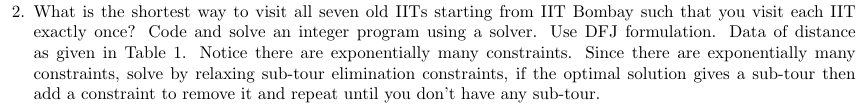

If we need to remove subtours manually by iterative method, then we can use the formulation given below:



$
\textbf{Decision Variables:}$
$$
\begin{align*}
& x_{ij} = \begin{cases}
    1 & \text{if edge } (i, j) \text{ is included in the tour} \\
    0 & \text{otherwise}
\end{cases}
\end{align*}
$$
$
\textbf{Objective Function:}$

$$
\begin{align*}
\text{Minimize } & \sum_{i=1}^{n} \sum_{j=1, j \neq i}^{n} c_{ij} \cdot x_{ij}
\end{align*}
$$


Where \( $c_{ij}$ \) represents the cost or distance between cities \( $i$ \) and \( $j$\)

$
\textbf{Constraints:}$


$\text{Outgoing Edges from Each City:}$
$$
\sum_{j=1, j \neq i}^{n} x_{ij} = 1 \quad \forall i \in \{1, 2, ..., n\} $$

$\text{Incoming Edges to Each City:} $
$$
\sum_{i=1, i \neq j}^{n} x_{ij} = 1 \quad \forall j \in \{1, 2, ..., n\}
$$


$
\textbf{Binary Variables:}
\begin{align*}
& x_{ij} \in \{0, 1\} \quad \text{for all } i, j \in \{1, 2, ..., n\}
\end{align*}
$

We are not worrying about the subtours write now. We will eliminate a subtour we encouter one.

In [ ]:
# Create Pyomo model
model = ConcreteModel()

# Define cities
num_cities = len(distances)
cities = list(range(num_cities))

# Define edges
edges = [(i, j) for i in cities for j in cities if i != j]

# Define decision variables
model.x = Var(edges, domain=Binary)

In [ ]:
# Define objective function
model.obj = Objective(expr=sum(distances[i,j] * model.x[i, j] for (i, j) in edges), sense=minimize)

# Define constraints
model.outgoing_edges = ConstraintList()
model.incoming_edges = ConstraintList()
for i in cities:
    model.outgoing_edges.add(sum(model.x[j, k] for (j, k) in edges if j == i) == 1)
    model.incoming_edges.add(sum(model.x[j, k] for (j, k) in edges if k == i) == 1)

In [ ]:
model.pprint()

1 Var Declarations
    x : Size=42, Index={(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5)}
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 4) :     0 :  None :     1 : False :  True : Binary
        (0, 5) :     0 :  None :     1 : False :  True : Binary
        (0, 6) :     0 :  None :     1 : False :  True : Binary
        (1, 0) :     0 :  None :     1 : False :  True : Binary
        (1, 2) :     0 :  None :     1 : False :  True : Binary
        (1, 3) :     0 :  None :     1 : Fals

In [ ]:
# Solve the initial relaxed model
result = SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model)

In [ ]:
result.solver.status

<SolverStatus.ok: 'ok'>

In [ ]:
result.solver.termination_condition

<TerminationCondition.optimal: 'optimal'>

In [ ]:
model.obj()

6179.0

In [ ]:
cities

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
#values of variable
try:
  print('Decision Variables for our model : ')
  for i in range(num_cities):
    for j in range(num_cities):
      if i !=j and (model.x[i,j].value == 1):
        print(f'x({i,j}) : ', model.x[i,j].value)
except:
  print("Problem has  Other than Optimal.")

Decision Variables for our model : 
x((0, 3)) :  1.0
x((1, 4)) :  1.0
x((2, 5)) :  1.0
x((3, 0)) :  1.0
x((4, 6)) :  1.0
x((5, 2)) :  1.0
x((6, 1)) :  1.0


In [ ]:
#using bfs variant to find subtours
def find_subtours():
    visited = {i: False for i in cities}
    subtours = []
    for i in cities:
        if not visited[i]:
            subtour = [i]
            j = i
            while True:
                visited[j] = True
                for k in cities:
                    if (j!= k) and (value(model.x[j, k]) > 0) and not visited[k]:
                        subtour.append(k)
                        j = k
                        break
                else:
                    break
            subtours.append(subtour)
    return subtours

In [ ]:
find_subtours()

[[0, 3], [1, 4, 6], [2, 5]]

We see that there are 3 subtours in the solution. Now we add a contraint to remove the (0,3) subtour. For that, we see that

$x_{0,3} + x_{3,0} \leq |\{0,3\}| -1$

$\implies x_{0,3} + x_{3,0} \leq 1$

let's involve this constraint.



In [ ]:
model.constraint1 = Constraint(expr = model.x[0,3] + model.x[3,0] <= 1)

In [ ]:
model.pprint()

1 Var Declarations
    x : Size=42, Index={(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5)}
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2) :     0 :   0.0 :     1 : False : False : Binary
        (0, 3) :     0 :   1.0 :     1 : False : False : Binary
        (0, 4) :     0 :   0.0 :     1 : False : False : Binary
        (0, 5) :     0 :   0.0 :     1 : False : False : Binary
        (0, 6) :     0 :   0.0 :     1 : False : False : Binary
        (1, 0) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : Fals

In [ ]:
# Solve the initial relaxed model
result = SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model)
print(result.solver.status)
print(result.solver.termination_condition)
#values of variable
try:
  print('Decision Variables for our model : ')
  for i in range(num_cities):
    for j in range(num_cities):
      if i !=j and (model.x[i,j].value == 1):
        print(f'x({i,j}) : ', model.x[i,j].value)
except:
  print("Problem has  Other than Optimal.")
print("Subtours in new model: " ,find_subtours())

ok
optimal
Decision Variables for our model : 
x((0, 1)) :  1.0
x((1, 3)) :  1.0
x((2, 5)) :  1.0
x((3, 0)) :  1.0
x((4, 6)) :  1.0
x((5, 2)) :  1.0
x((6, 4)) :  1.0
Subtours in new model:  [[0, 1, 3], [2, 5], [4, 6]]


In [ ]:
model.obj()

7059.0

In [ ]:
model.constraint2 = Constraint(expr = model.x[2,5] + model.x[5,2] <= 1)

In [ ]:
# Solve the initial relaxed model
result = SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model)
print(result.solver.status)
print(result.solver.termination_condition)
#values of variable
try:
  print('Decision Variables for our model : ')
  for i in range(num_cities):
    for j in range(num_cities):
      if i !=j and (model.x[i,j].value == 1):
        print(f'x({i,j}) : ', model.x[i,j].value)
except:
  print("Problem has  Other than Optimal.")
print("Subtours in new model: " ,find_subtours())

ok
optimal
Decision Variables for our model : 
x((0, 1)) :  1.0
x((1, 5)) :  1.0
x((2, 3)) :  1.0
x((3, 0)) :  1.0
x((4, 6)) :  1.0
x((5, 2)) :  1.0
x((6, 4)) :  1.0
Subtours in new model:  [[0, 1, 5, 2, 3], [4, 6]]


In [ ]:
model.obj()

7128.0

In [ ]:
model.constraint3 = Constraint(expr = model.x[4,6] + model.x[6,4] <= 1)

In [ ]:
# Solve the initial relaxed model
result = SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model)
print(result.solver.status)
print(result.solver.termination_condition)
#values of variable
try:
  print('Decision Variables for our model : ')
  for i in range(num_cities):
    for j in range(num_cities):
      if i !=j and (model.x[i,j].value == 1):
        print(f'x({i,j}) : ', model.x[i,j].value)
except:
  print("Problem has  Other than Optimal.")
print("Subtours in new model: " ,find_subtours())

ok
optimal
Decision Variables for our model : 
x((0, 3)) :  1.0
x((1, 6)) :  1.0
x((2, 5)) :  1.0
x((3, 2)) :  1.0
x((4, 0)) :  1.0
x((5, 1)) :  1.0
x((6, 4)) :  1.0
Subtours in new model:  [[0, 3, 2, 5, 1, 6, 4]]


Finally! After removing constraints one by one, we can see that there are no subtours and the final tour is:

$\{0,3,2,5,1,6,4,0\}$

If we observe the total objective we get: [we can also observe that objective value is increasing as we remove the subtours, because subtours have reduced objective cost but are not feasible tours]

In [ ]:
model.obj()

7689.0

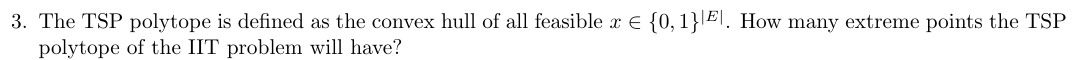

The number of extreme points of the TSP polytope for the IIT problem depends on the number of vertices in the graph (cities) and the connectivity of the graph.

In the case of the IIT problem, where the cities represent the old IITs and the edges represent the distances between them, the number of extreme points of the TSP polytope is exponential in the number of cities.

Specifically, for a graph with n cities, the number of extreme points of the TSP polytope can be calculated by seeing total valid tours possible. We first start at a vertex, where we start doesn't matter, we have to end up at the same node. Hence, moving from vertex to vertex, we have $(n-1)(n-2)....1 = (n-1)!$ possibilities. But since, we can go in reverse also, hence we are overcounting and the total number of actual valid tours possible are $\frac{(n-1)!}{2}$. This is because each extreme point corresponds to a permutation of the cities, representing a distinct tour.

For example, if there are 7 old IITs, the number of extreme points of the TSP polytope could be as large as **(6!/2)=360**.

It's worth noting that finding all extreme points of the TSP polytope is a computationally challenging task, especially for large graphs, due to the exponential explosion of possibilities. Therefore, in practice, algorithms often focus on finding good approximate solutions rather than exhaustively enumerating all extreme points.

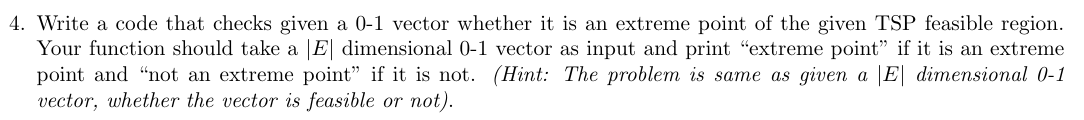

There are 42 edges. There is 1 if edge $i$ is choosen in that $|E|$ dimensional vector. A vector in an extreme point if it is a valid tour where it visits each city exactly once and that it satisfies the subtour elimination constraints.

In [ ]:
#let edge vector represent the following edges with respect to indexes:

###
#[(0, 1),(0, 2),(0, 3),(0, 4),(0, 5),(0, 6),(1, 0),(1, 2),(1, 3),(1, 4),(1, 5),(1, 6),
#(2, 0),(2, 1),(2, 3),(2, 4),(2, 5),(2, 6),(3, 0),(3, 1),(3, 2),(3, 4),(3, 5),(3, 6),
#(4, 0),(4, 1),(4, 2),(4, 3),(4, 5),(4, 6),(5, 0),(5, 1),(5, 2),(5, 3),(5, 4),(5, 6),
#(6, 0),(6, 1),(6, 2),(6, 3),(6, 4),(6, 5)]

###

Now if we say that vector is [1,0,0,0......0] we mean only edge (0,1) is selected.

In [ ]:
print(edges)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]


In [ ]:
def get_n_dimensional_vector(edges,n):

  #returns n dimensional vector based on selected edges. to be used in examples

  total = [(i, j) for i in range(n) for j in range(n) if i != j]
  vector = [0]*(n**2-n)
  for i, t in enumerate(total):
    if t in edges:
      vector[i] = 1
  return vector

In [ ]:
len(get_n_dimensional_vector([(0,2),(1,3),(2,4),(3,5),(4,1),(5,6),(6,0)],7))

42

In [ ]:
def is_extreme_point(vector, num_vertices):
  # Check if the vector is a valid tour (visits each city exactly once and subtours are not there)\
  edges_selected = []
  for index, edge in enumerate(vector):
    if edge == 1:
      edges_selected.append(edges[index])

  if len(edges_selected) != num_vertices:
    return False

  from_nodes = [edge[0] for edge in edges_selected]
  to_nodes = [edge[1] for edge in edges_selected]

  visited = [False] * num_vertices

  current_node = from_nodes[0]

  for i in range(len(from_nodes)):
    visited[current_node] = True
    current_node = to_nodes[current_node]

  if sum(visited) == num_vertices:
    return True
  else: return False

# Example usage:
# for example, [(0,2),(1,3),(2,4),(3,5),(4,1),(5,6),(6,0)]
# form a valid tour, hence writing this in 42 dimensional vector we get:
if is_extreme_point(get_n_dimensional_vector([(0,2),(1,3),(2,4),(3,5),(4,1),(5,6),(6,0)],7), 7):
    print("Extreme Point")
else:
    print("Not Extreme Point")

Extreme Point


In [ ]:
# Example usage:
# for example, [(0,2),(1,3),(2,4),(3,5),(4,1),(5,1)]
# DOES NOT form a valid tour, hence writing this in 42 dimensional vector we get:
if is_extreme_point(get_n_dimensional_vector([(0,2),(1,3),(2,4),(3,5),(4,1),(5,1)],7), 7):
    print("Extreme Point")
else:
    print("Not Extreme Point")

Not Extreme Point


As we see it outputs whether a path is valid or not.